# Dota 2 - Regression Analysis

* Trying to predict the total score of two teams based full match data

# RUN THIS BLOCK ONCE

In [1]:

%%capture
!conda update --all -y
!pip install --upgrade setuptools
!pip install xgboost
!pip install keras
!pip install tensorflow


In [2]:
# API IMPORTS
from __future__ import print_function
import time
from pprint import pprint
import json
import ast
from sklearn.exceptions import DataConversionWarning


# BASIC IMPORTS
import warnings
warnings.filterwarnings("ignore", category=DataConversionWarning)
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from statistics import mean, stdev
from scipy.stats import iqr

#SKLEARN IMPORTS
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import  MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# KERAS/TENSORFLOW IMPORTS
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping


# XGBOOST IMPORTS
from xgboost import XGBClassifier

Using TensorFlow backend.


# Basic Stats

In [3]:
def simple_stats(df):
    sorted(df['total_score'])
    q1, q3= np.percentile(df['total_score'],[25,75])
    inter_range = iqr(df['total_score'])
    lower_bound = q1 -(1.5 * inter_range) 
    upper_bound = q3 +(1.5 * inter_range) 
    print("IQR: ", inter_range)
    print("LOW: ", lower_bound)
    print("HIGH: ", upper_bound)
    print("Q1: ", q1)
    print("Q3: ", q3)
    
    
    plt.violinplot(df['total_score'], showmedians=True)
    plt.ylabel("Total Score")
    plt.xticks([])
    plt.show()

## Compute Accuracy with Range

In [4]:
def accuracy_calc(yTest, predictions, spread):
    num_tests = yTest.size
    correct = 0
    
    for l1,l2 in zip(yTest, predictions):
        if abs(l1 - l2) < spread:
            correct = correct + 1
            
    return correct/num_tests

# Linear Regression

In [5]:
def lin_reg(df):
    x = df.drop(['Unnamed: 0','total_score'], axis=1)
    y = df['total_score']

    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 2/5)
    linearRegressor = LinearRegression()
    linearRegressor.fit(xTrain, yTrain)
    yPrediction = linearRegressor.predict(xTest)

    predictions = [round(value) for value in yPrediction]

    accuracy = accuracy_score(yTest, predictions)
    print("LINEAR REGRESSION")
    print("---------------------------------")
    print("Exact Answer Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Accuracy with +/- 5 Spread: %.2f%%" % (accuracy_calc(yTest, yPrediction, 5) * 100.0))
    print("Accuracy with +/- 10 Spread: %.2f%%" % (accuracy_calc(yTest, yPrediction, 10) * 100.0))
    print("Accuracy with +/- 15 Spread: %.2f%%" % (accuracy_calc(yTest, yPrediction, 15) * 100.0))
    print("Root Mean Squared Error: %.2f" % sqrt(mean_squared_error(yTest, predictions)))
    print()
    print()

# Random Forest Regression

In [6]:
def rand_for(df):
    x = df.drop(['Unnamed: 0','total_score'], axis=1)
    y = df['total_score']

    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 2/5)
    forestRegressor = RandomForestRegressor(n_estimators=2000, max_depth=10)
    forestRegressor.fit(xTrain, yTrain)
    yPrediction = forestRegressor.predict(xTest)

    predictions = [round(value) for value in yPrediction]

    accuracy = accuracy_score(yTest, predictions)
    print("RANDOM FOREST REGRESSION")
    print("---------------------------------")
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Accuracy with +/- 5 Spread: %.2f%%" % (accuracy_calc(yTest, yPrediction, 5) * 100.0))
    print("Accuracy with +/- 10 Spread: %.2f%%" % (accuracy_calc(yTest, yPrediction, 10) * 100.0))
    print("Accuracy with +/- 15 Spread: %.2f%%" % (accuracy_calc(yTest, yPrediction, 15) * 100.0))
    print("Root Mean Squared Error: %.2f" % sqrt(mean_squared_error(yTest, predictions)))
    print()
    print()

# XGBoost

In [7]:
def xg_reg(df):
    x = df.drop(['Unnamed: 0','total_score'], axis=1)
    y = df['total_score']

    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 2/5)

    # fit model no training data
    model = XGBClassifier(scale_pos_weight=1,
                          learning_rate=0.01,  
                          subsample = 0.8,
                          objective='reg:squarederror', 
                          n_estimators=2000, 
                          reg_alpha = 0.3,
                          max_depth=40, 
                          gamma=10)

    model.fit(xTrain, yTrain)

    # make predictions for test data
    yPrediction = model.predict(xTest)
    predictions = [round(value) for value in yPrediction]

    # evaluate predictions
    accuracy = accuracy_score(yTest, predictions)
    print("XGBOOST REGRESSION")
    print("---------------------------------")
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Accuracy with +/- 5 Spread: %.2f%%" % (accuracy_calc(yTest, yPrediction, 5) * 100.0))
    print("Accuracy with +/- 10 Spread: %.2f%%" % (accuracy_calc(yTest, yPrediction, 10) * 100.0))
    print("Accuracy with +/- 15 Spread: %.2f%%" % (accuracy_calc(yTest, yPrediction, 15) * 100.0))
    print("Root Mean Squared Error: %.2f" % sqrt(mean_squared_error(yTest, predictions)))
    print()
    print()

# Neural Network
* Inspiration from: https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

In [8]:
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [9]:
def model_2():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(75, kernel_initializer='normal', activation='relu'))
    model.add(Dense(15, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [10]:
def nn_reg(df):
    x = df.drop(['Unnamed: 0','total_score'], axis=1)
    y = df['total_score'].values
    
    sc= MinMaxScaler()
    x= sc.fit_transform(x.astype(np.float))
    y= y.reshape(-1,1)
    y=sc.fit_transform(y.astype(np.float))
    
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

    
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 2/5)

    
    model = KerasRegressor(build_fn=larger_model, batch_size=5,epochs=5000, verbose=0, callbacks=[es])
    
    model.fit(xTrain,yTrain)

    # make predictions for test data
    yPrediction = model.predict(xTest)

    # evaluate predictions
    #accuracy = accuracy_score(yTest, yPrediction)
    print("NEURAL NETWORK REGRESSION")
    print("---------------------------------")
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Root Mean Squared Error: %.2f" % sqrt(mean_squared_error(yTest, yPrediction)))
    print()
    print()

In [11]:
def nn_reg_model2(df):
    x = df.drop(['Unnamed: 0','total_score'], axis=1)
    y = df['total_score'].values
    
    sc= MinMaxScaler()
    x= sc.fit_transform(x.astype(np.float))
    y= y.reshape(-1,1)
    y=sc.fit_transform(y.astype(np.float))
    
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

    
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 2/5)

    
    model = KerasRegressor(build_fn=model_2, batch_size=5,epochs=5000, verbose=0, callbacks=[es])
    
    model.fit(xTrain,yTrain)

    # make predictions for test data
    yPrediction = model.predict(xTest)

    # evaluate predictions
    #accuracy = accuracy_score(yTest, yPrediction)
    print("NEURAL NETWORK REGRESSION - Model 2")
    print("---------------------------------")
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Root Mean Squared Error: %.2f" % sqrt(mean_squared_error(yTest, yPrediction)))
    print()
    print()

# Automate All Tests

In [12]:
def run_all(df):
    simple_stats(df)
    lin_reg(df)
    rand_for(df)
    xg_reg(df)
    nn_reg(df)
    nn_reg_model2(df)

## Read CSVs

In [13]:
df_int = pd.read_csv("../../data/processed/Dalton/reg_int_full.csv")
df_prem = pd.read_csv("../../data/processed/Dalton/reg_prem_full.csv")
df_prof = pd.read_csv("../../data/processed/Dalton/reg_prof_full.csv")

## International Data Only

IQR:  21.0
LOW:  5.5
HIGH:  89.5
Q1:  37.0
Q3:  58.0


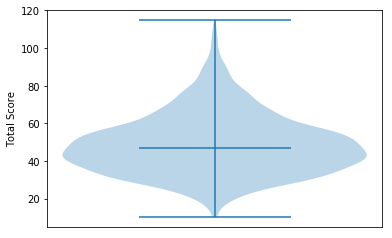

LINEAR REGRESSION
---------------------------------
Exact Answer Accuracy: 2.64%
Accuracy with +/- 5 Spread: 23.23%
Accuracy with +/- 10 Spread: 47.71%
Accuracy with +/- 15 Spread: 64.26%
Root Mean Squared Error: 16.46


RANDOM FOREST REGRESSION
---------------------------------
Accuracy: 2.09%
Accuracy with +/- 5 Spread: 24.06%
Accuracy with +/- 10 Spread: 47.01%
Accuracy with +/- 15 Spread: 65.09%
Root Mean Squared Error: 16.55


XGBOOST REGRESSION
---------------------------------
Accuracy: 3.34%
Accuracy with +/- 5 Spread: 22.95%
Accuracy with +/- 10 Spread: 46.87%
Accuracy with +/- 15 Spread: 65.23%
Root Mean Squared Error: 17.63


Epoch 00188: early stopping
NEURAL NETWORK REGRESSION
---------------------------------
Root Mean Squared Error: 0.15


Epoch 00365: early stopping
NEURAL NETWORK REGRESSION - Model 2
---------------------------------
Root Mean Squared Error: 0.17




In [14]:
run_all(df_int)

## Premier Tournaments and International Data

IQR:  21.0
LOW:  5.5
HIGH:  89.5
Q1:  37.0
Q3:  58.0


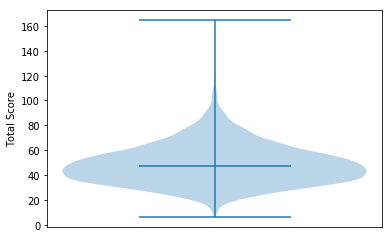

LINEAR REGRESSION
---------------------------------
Exact Answer Accuracy: 2.32%
Accuracy with +/- 5 Spread: 24.93%
Accuracy with +/- 10 Spread: 47.65%
Accuracy with +/- 15 Spread: 66.16%
Root Mean Squared Error: 16.10


RANDOM FOREST REGRESSION
---------------------------------
Accuracy: 2.27%
Accuracy with +/- 5 Spread: 25.04%
Accuracy with +/- 10 Spread: 47.36%
Accuracy with +/- 15 Spread: 66.58%
Root Mean Squared Error: 16.17


XGBOOST REGRESSION
---------------------------------
Accuracy: 2.08%
Accuracy with +/- 5 Spread: 22.06%
Accuracy with +/- 10 Spread: 44.02%
Accuracy with +/- 15 Spread: 63.21%
Root Mean Squared Error: 17.68


Epoch 00034: early stopping
NEURAL NETWORK REGRESSION
---------------------------------
Root Mean Squared Error: 0.10


Epoch 00248: early stopping
NEURAL NETWORK REGRESSION - Model 2
---------------------------------
Root Mean Squared Error: 0.10




In [15]:
run_all(df_prem)

## All Professional Matches in Dataset

IQR:  24.0
LOW:  3.0
HIGH:  99.0
Q1:  39.0
Q3:  63.0


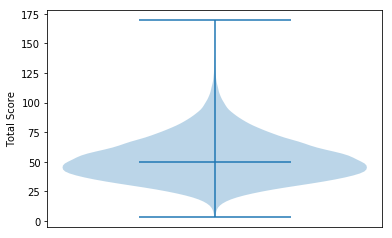

LINEAR REGRESSION
---------------------------------
Exact Answer Accuracy: 2.09%
Accuracy with +/- 5 Spread: 21.37%
Accuracy with +/- 10 Spread: 41.87%
Accuracy with +/- 15 Spread: 59.69%
Root Mean Squared Error: 18.35


RANDOM FOREST REGRESSION
---------------------------------
Accuracy: 2.03%
Accuracy with +/- 5 Spread: 21.22%
Accuracy with +/- 10 Spread: 41.82%
Accuracy with +/- 15 Spread: 60.25%
Root Mean Squared Error: 18.19


XGBOOST REGRESSION
---------------------------------
Accuracy: 2.25%
Accuracy with +/- 5 Spread: 19.61%
Accuracy with +/- 10 Spread: 40.14%
Accuracy with +/- 15 Spread: 57.21%
Root Mean Squared Error: 20.28


Epoch 00081: early stopping
NEURAL NETWORK REGRESSION
---------------------------------
Root Mean Squared Error: 0.11


Epoch 00126: early stopping
NEURAL NETWORK REGRESSION - Model 2
---------------------------------
Root Mean Squared Error: 0.11




In [16]:
## Some extra columns came in with the professional dataset, drop them and run_all

df_prof = df_prof.drop(['Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1'], axis=1)

run_all(df_prof)